# Preprocessing I
## Feature Importance
Feature Importance: After establishing that certain GIDs have different abundances across categories, we can further delve into which specific GIDs are the most influential in determining the category. This can be done using techniques like:

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

In [16]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
whole_taxa_o = pd.read_excel('data/taxa_mit_whole.xlsx', header=[0,1,2,3,4,5,6], dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}},  skiprows=[7]) # Somehow it was showing an empty row, so skiprow deletes it

Influencers_taxa_o = pd.read_excel('data/taxa_mit_influencers.xlsx', header=[0,1,2,3,4,5,6], dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}},  skiprows=[7]) # Somehow it was showing an empty row, so skiprow deletes it

In [17]:
Influencers_taxa_o.head()

,Unnamed: 0_level_0,Category,Actinomycetales_Actinomycetaceae_Actinomyces,Burkholderiales_Comamonadaceae_Aquabacterium,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Pasteurellales_Pasteurellaceae_Haemophilus,Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium,Legionellales_Legionellaceae_Legionella,...,Caulobacterales_Caulobacteraceae_Phenylobacterium,Bacteroidales_Porphyromonadaceae_Porphyromonas,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Rhodospirillales_Acetobacteraceae_Roseococcus,Sphingomonadales_Sphingomonadaceae_Sphingosinicella,Burkholderiales_Comamonadaceae_Tepidimonas,Thermales_Thermaceae_Thermus,Burkholderiales_Comamonadaceae_Variovorax,Clostridiales_Veillonellaceae_Veillonella,Rhizobiales_Xanthobacteraceae_Xanthobacter
,Unnamed: 0_level_1,Unnamed: 1_level_1,Actinobacteria,Proteobacteria,Firmicutes,Actinobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,...,Proteobacteria,Bacteroidetes,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Thermi,Proteobacteria,Firmicutes,Proteobacteria
,Unnamed: 0_level_2,Unnamed: 1_level_2,Actinobacteria,Betaproteobacteria,Clostridia,Actinobacteria,Clostridia,Gammaproteobacteria,Alphaproteobacteria,Gammaproteobacteria,...,Alphaproteobacteria,Bacteroidia,Gammaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Deinococci,Betaproteobacteria,Clostridia,Alphaproteobacteria
,Unnamed: 0_level_3,Unnamed: 1_level_3,Actinomycetales,Burkholderiales,Clostridiales,Actinomycetales,Thermoanaerobacterales,Pasteurellales,Rhizobiales,Legionellales,...,Caulobacterales,Bacteroidales,Vibrionales,Rhodospirillales,Sphingomonadales,Burkholderiales,Thermales,Burkholderiales,Clostridiales,Rhizobiales
,Unnamed: 0_level_4,Unnamed: 1_level_4,Actinomycetaceae,Comamonadaceae,Clostridiaceae,Corynebacteriaceae,Thermoanaerobacteraceae,Pasteurellaceae,Hyphomicrobiaceae,Legionellaceae,...,Caulobacteraceae,Porphyromonadaceae,Pseudoalteromonadaceae,Acetobacteraceae,Sphingomonadaceae,Comamonadaceae,Thermaceae,Comamonadaceae,Veillonellaceae,Xanthobacteraceae
,Unnamed: 0_level_5,Unnamed: 1_level_5,Actinomyces,Aquabacterium,Clostridium,Corynebacterium,Gelria,Haemophilus,Hyphomicrobium,Legionella,...,Phenylobacterium,Porphyromonas,Pseudoalteromonas,Roseococcus,Sphingosinicella,Tepidimonas,Thermus,Variovorax,Veillonella,Xanthobacter
,Unnamed: 0_level_6,Unnamed: 1_level_6,23,91,214,229,334,351,375,408,...,549,565,584,625,678,712,725,863,864,871
0,site_1,3,0.2801,0.1939,0.0000,0.0000,0.0215,0.4739,0.5816,0.0000,...,0.2154,0.1723,0.0000,0.0000,0.0000,0.0000,0.4524,1.6588,0.3231,0.0000
1,site_2,1,1.2332,0.1138,0.0000,0.0000,0.0000,0.6261,0.7020,0.0000,...,0.3035,0.2466,0.0000,0.0000,0.0000,0.0000,0.3035,2.1628,3.2821,0.0000
2,site_3,1,0.3069,0.2332,0.0000,0.0000,0.0000,0.4297,0.6875,0.0000,...,0.3069,1.4854,0.0000,0.0000,0.0000,0.0123,3.5846,0.8102,0.2946,0.0000
3,site_4,1,2.2016,0.1410,0.0000,0.0000,0.0022,5.0709,0.6016,0.0044,...,0.2292,4.4009,0.0000,0.0044,0.0000,0.0000,2.0539,1.5360,2.8605,0.0000


Both of the dfs are prepared to make PCA analysis 

In [18]:
whole_taxa_o.head(2)

,Unnamed: 0_level_0,Category,Actinomycetales_Actinomycetaceae_Actinomyces,Thermoanaerobacterales_Thermoanaerobacteraceae_Ammonifex,Rhizobiales_Rhodobiaceae_Anderseniella,Rhizobiales_Hyphomicrobiaceae_Aquabacter,Burkholderiales_Comamonadaceae_Aquabacterium,Rhizobiales_Phyllobacteriaceae_Aquamicrobium,Actinomycetales_Dermabacteraceae_Brachybacterium,Actinomycetales_Promicromonosporaceae_Cellulosimicrobium,...,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Xanthomonadale_Rhodobacteraceae_Rhodanobacter,Rhodospirillales_Acetobacteraceae_Roseococcus,Rhizobiales_Rhizobiaceae_Shinella,Sphingomonadales_Sphingomonadaceae_Sphingosinicella,Burkholderiales_Comamonadaceae_Tepidimonas,Thermales_Thermaceae_Thermus,Spirochaetales_Spirochaetaceae_Spirochaetaceae_unclassified,Rhodocyclales_Rhodocyclaceae_Uncultured_bacterium,Rhizobiales_Xanthobacteraceae_Xanthobacter
,Unnamed: 0_level_1,Unnamed: 1_level_1,Actinobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Actinobacteria,Actinobacteria,...,Proteobacteria,Pseudomonadota,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Thermi,Spirochaetae,Proteobacteria,Proteobacteria
,Unnamed: 0_level_2,Unnamed: 1_level_2,Actinobacteria,Clostridia,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Alphaproteobacteria,Actinobacteria,Actinobacteria,...,Gammaproteobacteria,Gammaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Deinococci,Spirochaetes,Betaproteobacteria,Alphaproteobacteria
,Unnamed: 0_level_3,Unnamed: 1_level_3,Actinomycetales,Thermoanaerobacterales,Rhizobiales,Rhizobiales,Burkholderiales,Rhizobiales,Actinomycetales,Actinomycetales,...,Vibrionales,Xanthomonadale,Rhodospirillales,Rhizobiales,Sphingomonadales,Burkholderiales,Thermales,Spirochaetales,Rhodocyclales,Rhizobiales
,Unnamed: 0_level_4,Unnamed: 1_level_4,Actinomycetaceae,Thermoanaerobacteraceae,Rhodobiaceae,Hyphomicrobiaceae,Comamonadaceae,Phyllobacteriaceae,Dermabacteraceae,Promicromonosporaceae,...,Pseudoalteromonadaceae,Rhodobacteraceae,Acetobacteraceae,Rhizobiaceae,Sphingomonadaceae,Comamonadaceae,Thermaceae,Spirochaetaceae,Rhodocyclaceae,Xanthobacteraceae
,Unnamed: 0_level_5,Unnamed: 1_level_5,Actinomyces,Ammonifex,Anderseniella,Aquabacter,Aquabacterium,Aquamicrobium,Brachybacterium,Cellulosimicrobium,...,Pseudoalteromonas,Rhodanobacter,Roseococcus,Shinella,Sphingosinicella,Tepidimonas,Thermus,Spirochaetaceae_unclassified,Uncultured_bacterium,Xanthobacter
,Unnamed: 0_level_6,Unnamed: 1_level_6,23,79,88,90,91,92,140,201,...,584,605,625,657,678,712,725,771,799,871
0,site_1,3,0.2801,0.0000,0.0000,0.0000,0.1939,0.0000,0.0000,0.0000,...,0.0000,0.6247,0.0000,0.0000,0.0000,0.0000,0.4524,0.0000,0.0000,0.0000
1,site_2,1,1.2332,0.0000,0.0190,0.0000,0.1138,0.0000,0.0000,0.0000,...,0.0000,0.8348,0.0000,0.0000,0.0000,0.0000,0.3035,0.0000,0.0000,0.0000


Preparing df whole_taxa_o

In [19]:
whole_taxa_o = whole_taxa_o.rename(columns= {"Unnamed: 0_level_0": "Sites"})
# Deleting headers names of unnamed levels
whole_taxa_o.columns = whole_taxa_o.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
whole_taxa_o['Sites'] = whole_taxa_o['Sites'].astype(str)
whole_taxa_o['Category'] = whole_taxa_o['Category'].astype(int)
whole_taxa_o= whole_taxa_o.set_index("Sites")

Preparing dataframe Influencers_taxa_o

In [20]:
Influencers_taxa_o = Influencers_taxa_o.rename(columns= {"Unnamed: 0_level_0": "Sites"})
# Deleting headers names of unnamed levels
Influencers_taxa_o.columns = Influencers_taxa_o.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
Influencers_taxa_o['Sites'] = Influencers_taxa_o['Sites'].astype(str)
Influencers_taxa_o['Category'] = Influencers_taxa_o['Category'].astype(int)
Influencers_taxa_o= Influencers_taxa_o.set_index("Sites")

In [21]:
Influencers_taxa_o.columns

MultiIndex([(                                             'Category', ...),
            (         'Actinomycetales_Actinomycetaceae_Actinomyces', ...),
            (         'Burkholderiales_Comamonadaceae_Aquabacterium', ...),
            (             'Clostridiales_Clostridiaceae_Clostridium', ...),
            (   'Actinomycetales_Corynebacteriaceae_Corynebacterium', ...),
            ('Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria', ...),
            (           'Pasteurellales_Pasteurellaceae_Haemophilus', ...),
            (         'Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium', ...),
            (              'Legionellales_Legionellaceae_Legionella', ...),
            (           'Caulobacterales_Caulobacteraceae_Mycoplana', ...),
            (          'Rhodobacterales_Rhodobacteraceae_Paracoccus', ...),
            (    'Caulobacterales_Caulobacteraceae_Phenylobacterium', ...),
            (       'Bacteroidales_Porphyromonadaceae_Porphyromonas', ...),
            

In [22]:
# Droping Category yet Influencers_taxa_o still has category
Influencers_taxa = Influencers_taxa_o.drop(columns=['Category'], level=0)
#Storing original columns to use them later
X_Influencers_taxa = Influencers_taxa.copy()
# Convert tuple-like multi-index columns to strings for the copy
X_Influencers_taxa.columns = X_Influencers_taxa.columns.map(str)

In [23]:
# Standardize the data
X_standardized_influencers= StandardScaler().fit_transform(X_Influencers_taxa)
X_standardized_influencers = pd.DataFrame(X_standardized_influencers, columns=X_Influencers_taxa.columns)

In [24]:
# Compute PCA
pca_influencers = PCA(n_components=2)  # We're only taking the first two principal components for visualization
principal_components_influencers = pca_influencers.fit_transform(X_standardized_influencers)
# Convert the principal components to a DataFrame for easier plotting
pca_df_i = pd.DataFrame(data=principal_components_influencers, columns=['PC1', 'PC2'])

pca_influential_features = PCA()
pca_influential_features.fit(X_standardized_influencers)
explained_variances_influential = pca_influential_features.explained_variance_ratio_

pca_df_i['Category'] = Influencers_taxa_o['Category'].values

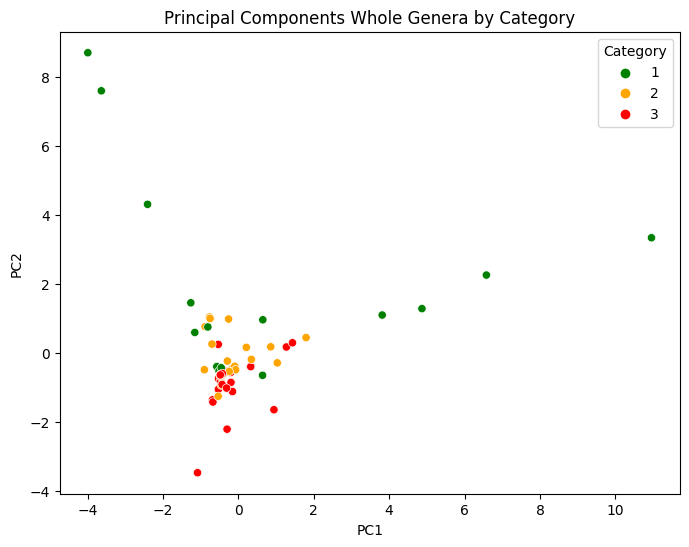

In [25]:
# Create a figure for the plot
plt.figure(figsize=(8, 6))
plt.title('Principal Components Whole Genera by Category')

# Now, plot PC1 vs PC2 and color the points by 'Category'
colors = ['green', 'orange', 'red']  # Replace with your desired colors
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df_i, palette=colors)

plt.show()

**Influencers Genera Dataframe (`influencers_final`)**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and the others.
   - Category 3 forms a linear pattern between PC1 and PC2, suggesting a gradient or continuum of variance explained by these components.
   - Category 2 dots align at the end of this linear pattern, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'Y' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories,

In [26]:
whole_taxa_o.head()

,Category,Actinomycetales_Actinomycetaceae_Actinomyces,Thermoanaerobacterales_Thermoanaerobacteraceae_Ammonifex,Rhizobiales_Rhodobiaceae_Anderseniella,Rhizobiales_Hyphomicrobiaceae_Aquabacter,Burkholderiales_Comamonadaceae_Aquabacterium,Rhizobiales_Phyllobacteriaceae_Aquamicrobium,Actinomycetales_Dermabacteraceae_Brachybacterium,Actinomycetales_Promicromonosporaceae_Cellulosimicrobium,Clostridiales_Clostridiaceae_Clostridium,...,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Xanthomonadale_Rhodobacteraceae_Rhodanobacter,Rhodospirillales_Acetobacteraceae_Roseococcus,Rhizobiales_Rhizobiaceae_Shinella,Sphingomonadales_Sphingomonadaceae_Sphingosinicella,Burkholderiales_Comamonadaceae_Tepidimonas,Thermales_Thermaceae_Thermus,Spirochaetales_Spirochaetaceae_Spirochaetaceae_unclassified,Rhodocyclales_Rhodocyclaceae_Uncultured_bacterium,Rhizobiales_Xanthobacteraceae_Xanthobacter
,,Actinobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Actinobacteria,Actinobacteria,Firmicutes,...,Proteobacteria,Pseudomonadota,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Thermi,Spirochaetae,Proteobacteria,Proteobacteria
,,Actinobacteria,Clostridia,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Alphaproteobacteria,Actinobacteria,Actinobacteria,Clostridia,...,Gammaproteobacteria,Gammaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Deinococci,Spirochaetes,Betaproteobacteria,Alphaproteobacteria
,,Actinomycetales,Thermoanaerobacterales,Rhizobiales,Rhizobiales,Burkholderiales,Rhizobiales,Actinomycetales,Actinomycetales,Clostridiales,...,Vibrionales,Xanthomonadale,Rhodospirillales,Rhizobiales,Sphingomonadales,Burkholderiales,Thermales,Spirochaetales,Rhodocyclales,Rhizobiales
,,Actinomycetaceae,Thermoanaerobacteraceae,Rhodobiaceae,Hyphomicrobiaceae,Comamonadaceae,Phyllobacteriaceae,Dermabacteraceae,Promicromonosporaceae,Clostridiaceae,...,Pseudoalteromonadaceae,Rhodobacteraceae,Acetobacteraceae,Rhizobiaceae,Sphingomonadaceae,Comamonadaceae,Thermaceae,Spirochaetaceae,Rhodocyclaceae,Xanthobacteraceae
,,Actinomyces,Ammonifex,Anderseniella,Aquabacter,Aquabacterium,Aquamicrobium,Brachybacterium,Cellulosimicrobium,Clostridium,...,Pseudoalteromonas,Rhodanobacter,Roseococcus,Shinella,Sphingosinicella,Tepidimonas,Thermus,Spirochaetaceae_unclassified,Uncultured_bacterium,Xanthobacter
,,23,79,88,90,91,92,140,201,214,...,584,605,625,657,678,712,725,771,799,871
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.2801,0.0000,0.0000,0.0000,0.1939,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.6247,0.0000,0.0000,0.0000,0.0000,0.4524,0.0000,0.0000,0.0000
site_2,1,1.2332,0.0000,0.0190,0.0000,0.1138,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.8348,0.0000,0.0000,0.0000,0.0000,0.3035,0.0000,0.0000,0.0000
site_3,1,0.3069,0.0000,0.0123,0.0000,0.2332,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.7979,0.0000,0.0000,0.0000,0.0123,3.5846,0.0000,0.0000,0.0000


In [39]:
# Droping Category, yet whole_tax_o still has category
whole_tax = whole_taxa_o.drop(columns=['Category'], level=0)
#Storing original columns to use them later
X_whole_tax =whole_tax.copy()
# Convert tuple-like multi-index columns to strings for the copy
X_whole_tax.columns = X_whole_tax.columns.map(str)
# Standardize the data
X_standardized_whole= StandardScaler().fit_transform(X_whole)
X_standardized_whole = pd.DataFrame(X_standardized_whole, columns=X_whole.columns)

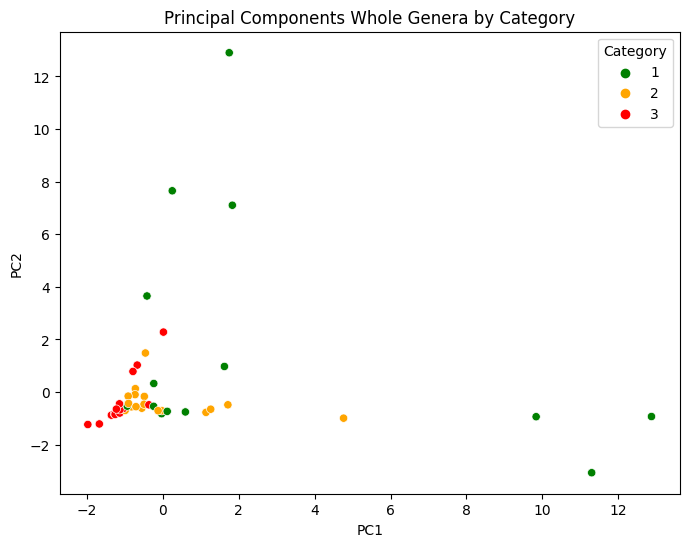

In [40]:
# Compute PCA
pca_whole = PCA(n_components=2)  # We're only taking the first two principal components for visualization
principal_components = pca_whole.fit_transform(X_standardized_whole)

# Convert the principal components to a DataFrame for easier plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Category'] = whole_taxa_o['Category'].values

# Create a figure for the plot
plt.figure(figsize=(8, 6))
plt.title('Principal Components Whole Genera by Category')

# Now, plot PC1 vs PC2 and color the points by 'Category'
colors = ['green', 'orange', 'red']  # Replace with your desired colors
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)

plt.show()

**Whole Data**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.
   - Category 3, although forming a linear pattern, also has a few dots that spread out, indicating some variability within this category.
   - The mixed pattern observed suggests a more intricate relationship among the categories, possibly due to the inclusion of a broader set of genera in the whole data.
**Interpretation**:
 The distinct linear pattern of category 3 and 1 in both dataframes suggests a consistent underlying structure or set of interactions. However, the whole data presents a more convoluted picture, with overlaps and mixed patterns. This complexity might arise from the inclusion of a broader set of genera, some of which might not be as influential or distinct as the ones in the `influencers_final` dataframe.

### Computing how many features would be necesary to explain the whole data

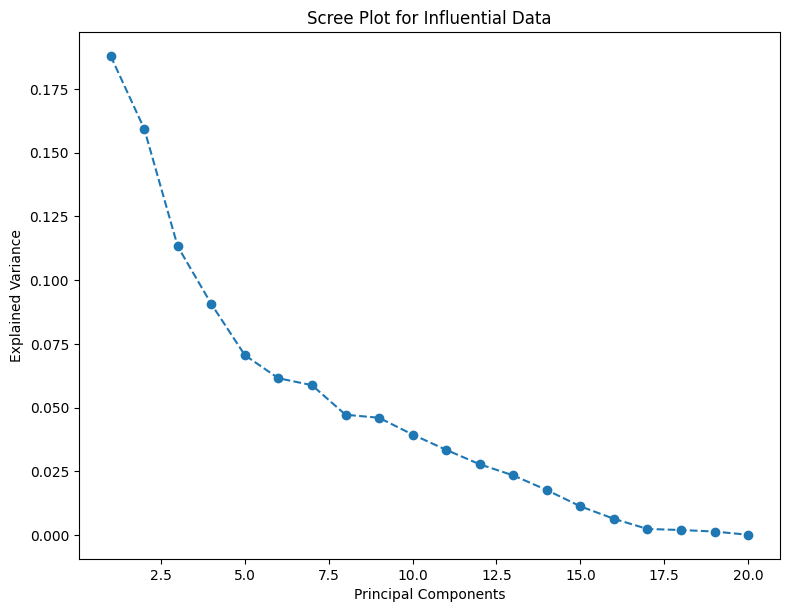

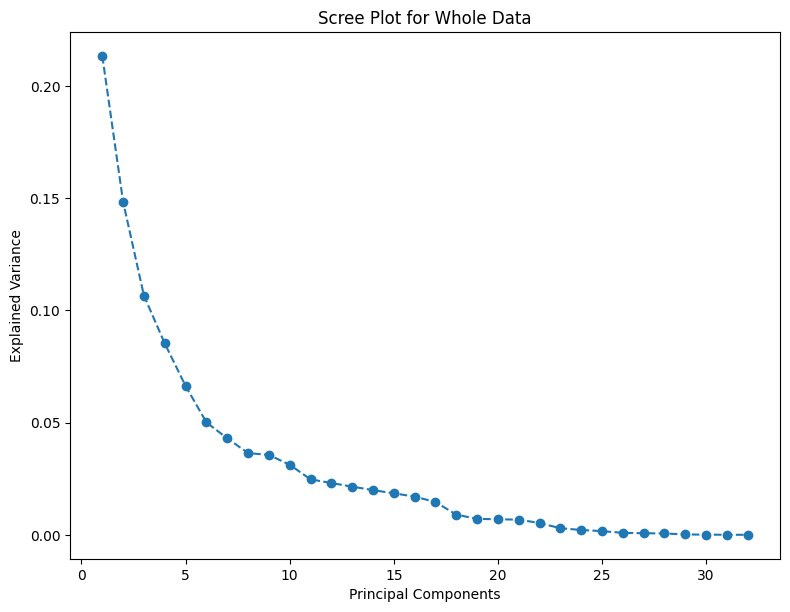

In [29]:
pca_influential_features = PCA()
pca_influential_features.fit(X_standardized_influencers)
explained_variances_influential = pca_influential_features.explained_variance_ratio_

pca_whole_features = PCA()
pca_whole_features.fit(X_standardized_whole )
explained_variances_whole = pca_whole_features.explained_variance_ratio_

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', linestyle='--')
    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Components')
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Plotting for pca_influential
plot_scree(pca_influential_features, "Scree Plot for Influential Data")

#Plotting for pca_whole
plot_scree(pca_whole_features, "Scree Plot for Whole Data")


1. Influencers Genera:
The PCA plot for the influencers shows distinct clustering, indicating specific patterns within these genera. The first few principal components capture significant variance, suggesting that there are strong underlying structures or patterns in this subset of the data. This could be due to specific biological characteristics or interactions that are more pronounced in these influential genera.

2. Whole Data:
For the entire dataset, the PCA plot displays a more dispersed distribution of data points. The smooth decline in explained variance across principal components suggests that the variance is spread more evenly across the features. This is expected as the whole dataset encompasses a broader range of genera, each contributing to the overall variance.

__Interpretation:__
The distinct patterns observed in the PCA plots can provide insights into the relationships and interactions between different genera. For instance, closely clustered points in the PCA space might indicate genera with similar biological properties or ecological roles. Furthermore, the difference in patterns between the influencers_final and whole data suggests that the influential genera have specific characteristics that set them apart from the rest. This could be of particular interest for further biological investigations, as understanding these key influencers can shed light on crucial microbial interactions or pathways.

In addition to PCA, we also assessed feature importance using a RandomForest model. This analysis ranked the original features based on their predictive power. While PCA highlighted the overall structure of the data, the RandomForest feature importance provided a direct measure of which genera (features) are most influential in predicting our target variable.

## Feature Importance Influencers_taxa df
Using ramdom forest to get the importance of each feature in the model.
we have already defined X in the previous snipets: 

In [41]:
# Extract the GID columns (excluding 'Site' and 'Category'),  X being feature matrix and y being target variable
X_Influencers_taxa = Influencers_taxa_o.drop(columns=['Category'], level=0)
y_influencers = Influencers_taxa_o["Category"]

# Convert tuple-like multi-index columns to strings for the copy
X_Influencers_taxa.columns = X_Influencers_taxa.columns.map(str)

In [42]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_Influencers_taxa, y_influencers, test_size=0.2, random_state=42)
#reshaping y_train and y_test that complained about needed to be a 1d array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [43]:
#standarising the features
scaler = StandardScaler()
X_influencers_train_scaled = scaler.fit_transform(X_train)
X_influencers_test_scaled = scaler.transform(X_test)

In [44]:
# Create a pipeline with PCA and RandomForestRegressor
pipeline = Pipeline([
     ('rf', RandomForestRegressor(n_estimators=100, random_state=42))])

In [45]:
# Fit the pipeline to the training data
pipeline.fit(X_influencers_train_scaled, y_train)

Pipeline(steps=[('rf', RandomForestRegressor(random_state=42))])

### Step 2: Model Evaluation

In [46]:
# Cross-validation
scores = cross_val_score(pipeline, X_influencers_train_scaled, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

Cross-validation scores: [ 0.07411176  0.4428     -0.290025   -0.4911325   0.01428421]
Average cross-validation score: -0.04999230495356044


In [47]:
# Predict the labels of the test set
y_pred = pipeline.predict(X_influencers_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.32472857142857153


### Step 3: Extract Feature Importances

In [48]:
# Extract feature importances from RandomForestRegressor
feature_importances = pipeline.named_steps['rf'].feature_importances_
feature_importances

array([0.05139512, 0.01990303, 0.09549364, 0.03614273, 0.01489238,
       0.0292173 , 0.06036276, 0.08702337, 0.01659743, 0.11675527,
       0.27707125, 0.00704322, 0.01379138, 0.07506223, 0.01389979,
       0.00626955, 0.01194348, 0.02370998, 0.02976738, 0.01365873])

In [49]:
# Extract GID and Join_tax from the multi-index
GID = Influencers_taxa_o.columns.get_level_values(6).to_list()
Join_tax = Influencers_taxa_o.columns.get_level_values(0).to_list()

# Create a DataFrame to view the results
df_importances = pd.DataFrame({
    'GID' : GID,
    'Join_tax': Join_tax,
    'Importance': feature_importances
})

# Sort the features by importance
Influencers_importance = df_importances.sort_values(by='Importance', ascending=False)
Influencers_importance["Join_tax"] = Influencers_importance["Join_tax"].str.strip()
pd.set_option('display.max_rows', 100)  # Display up to 500 rows

ValueError: All arrays must be of the same length

In [ ]:
Influencers_importance 

### Random Forest tree

In [ ]:
# Plot the tree
plt.figure(figsize=(25,15))
plot_tree(rf.estimators_[0], 
          filled=True, 
          feature_names=X_Influencers_taxa_names.columns.get_level_values(5).to_list(),  # Using column names from X_train
          class_names=['1', '2', '3'], 
          proportion=True)
plt.show()

## Pipeline for Feature Importance using rf and Explained Variance using PCA 
from Notebook Filtering.ipynb after statistical Analyis : without filtering but with Ordinary Least Squares (OLS) regression analysis for whole. And for influencers after filtering on notebook 2 and OLS. For uniques after singling out the unique genera in each category and uniques_23 including genera on both fail analysis category but without OLS.
Now we doing for those df:
* __Feature importances__ from RFR give us an idea of which features are most influential in making predictions.
* __The explained variance__ from PCA tells us how much of the data's total variance is captured by each principal component.

### Pipeline for Feature Importance using Random Forest

In [ ]:
#Reading the data
whole = pd.read_excel('data/taxa_mit_whole.xlsx', header=[0,1,2,3,4,5,6])
Influencers = pd.read_excel('data/taxa_mit_influencers.xlsx', header=[0,1,2,3,4,5,6])
uniques = pd.read_excel('data/tax_unique.xlsx', header=[0,1,2,3,4,5,6])
uniques_23 = pd.read_excel('data/tax_unique_plus_23.xlsx', header=[0,1,2,3,4,5,6])

pd.set_option('display.max_rows', 100)  # Display up to 500 rows

In [ ]:
def apply_pipeline(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 
    # making sure that the levels all are on str mode
    df.columns = df.columns.set_levels([level.astype(str) for level in df.columns.levels])

    #deleting the first column that is the index and the first row that is with nans
    df= df.drop(columns=df.columns[0]).drop(index=df.index[0])
    #setting the index to be Sites
    df = df.set_index("Sites")
    #Correcting the Tuple-like Index
    df.index = df.index.map(lambda x: x[0] if isinstance(x, tuple) else x)
    
    #creating df to put the names on final df coming from original copy
    X_names = df.drop(columns='Category', level=0)
    # Putting label Category' column as the target variable
    X = X_names.copy()
    y = df['Category']
    # Convert tuple-like multi-index columns to strings for the copy
    X.columns = X.columns.map(str)
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #reshaping y_train and y_test that complained about needed to be a 1d array
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    #K-Fold cross-validation to evaluate the model on different folds during cross-validation.
    kf = KFold(n_splits=5)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    
        # Fit and predict
        rf_pipeline.fit(X_train, y_train)
        # Predict the labels of the test set
        y_pred = rf_pipeline.predict(X_test)
    
        # Calculate and store MAE
        mae = mean_absolute_error(y_test, y_pred).round(4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
      
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_pred).round(4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Extract GID and Join_tax from the multi-index
    GID = X_names.columns.get_level_values(6).to_list()
    Join_tax = X_names.columns.get_level_values(0).to_list()

    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
            'GID' : GID,
            'Join_tax': Join_tax,
            'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False) # Sort the features by importance
    
    #Clean leading spaces on genus
    df_importances_rf["Join_tax"] = df_importances_rf["Join_tax"].str.replace(r'^\s+', '', regex=True)
    
    print(f'Feature Importance by RF: {df_importances_rf}')
          
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

In [ ]:
# Apply the pipeline the working df
whole_pipeline, df_importances_rf = apply_pipeline(whole, "Whole")

In [ ]:
Influencers_pipeline, df_importances_rf = apply_pipeline(Influencers, "Influencers")

In [ ]:
uniques_pipeline, df_importances_rf = apply_pipeline(uniques, "Uniques")

In [ ]:
uniques_23_pipeline, df_importances_rf= apply_pipeline(uniques_23, "Uniques_23")

In [ ]:
#Reading the data
whole = pd.read_excel('data/taxa_mit_whole.xlsx', header=[0,1,2,3,4,5,6])
Influencers = pd.read_excel('data/taxa_mit_influencers.xlsx', header=[0,1,2,3,4,5,6])
uniques = pd.read_excel('data/tax_unique.xlsx', header=[0,1,2,3,4,5,6])
uniques_23 = pd.read_excel('data/tax_unique_plus_23.xlsx', header=[0,1,2,3,4,5,6])

pd.set_option('display.max_rows', 100)  # Display up to 500 rows

### __pipeline for pca variance__

In [ ]:
def apply_pipeline_pca(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 
    # making sure that the levels all are on str mode
    df.columns = df.columns.set_levels([level.astype(str) for level in df.columns.levels])

    #deleting the first column that is the index and the first row that is with nans
    df= df.drop(columns=df.columns[0]).drop(index=df.index[0])
    #setting the index to be Sites
    df = df.set_index("Sites")
    #Correcting the Tuple-like Index
    df.index = df.index.map(lambda x: x[0] if isinstance(x, tuple) else x)
    
    #creating df to put the names on final df coming from original copy
    X_names = df.drop(columns='Category', level=0)
    # Putting label Category' column as the target variable
    X = X_names.copy()
    y = df['Category']
    # Convert tuple-like multi-index columns to strings for the copy
    X.columns = X.columns.map(str)
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #reshaping y_train and y_test that complained about needed to be a 1d array
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # checking the model with Kfold

    kf = KFold(n_splits=5)
    
    pca_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
          X_train, X_test = X.iloc[train_index], X.iloc[test_index]
          y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                      
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
      
    #Get the loadings from the PCA object the loadings/coeficients from the original df features, we look which variance explain which feature.
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
         
    # Extract GID and Join_tax from the multi-index
    GID = X_names.columns.get_level_values(6).to_list()
    Join_tax = X_names.columns.get_level_values(0).to_list()

    # We create a df to easy interprete the results
    df_pca_influence = pd.DataFrame({
         'GID' : GID,
         'Join_tax': Join_tax,
         'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False) # Sort the features by influence
    
    #Clean leading spaces on genus
    df_pca_influence["Join_tax"] = df_pca_influence["Join_tax"].str.replace(r'^\s+', '', regex=True)
    
    print(f'Number of components selected by PCA: {n_components}')
    print(f'Explained Variance by Original Feature: {df_pca_influence}')
    
    return pca_pipeline, df_pca_influence

In [ ]:
# Apply the pipeline the working df
whole_pca_pipeline, df_pca_influence = apply_pipeline_pca(whole, "Whole")

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
Influencers_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(Influencers, "Influencers")

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
uniques_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(uniques, "Uniques")

In [ ]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

In [ ]:
uniques_23_pca_pipe_influence, df_pca_influence = apply_pipeline_pca(uniques_23, "Uniques_23")

In [ ]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

### Manually prunning the features according to importance and influence

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

I put all dataframes whole, Influencers, Uniques, Uniques_23 
Selected_Gids = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}

In [ ]:
# The df were compared on excel, the most important features and influencial with pca and rf were selected on each df and pruned for replicates, then all df were mixed and chosen the following genera
selected_dfs_gen = 154,201, 214, 229, 334,351, 408, 354, 497,512,565, 581, 583, 584, 606, 621, 625
#selected_dfs_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512 # new selected-->
selected_dfs_gen = set(map(str, selected_dfs_gen))

In [ ]:
# Initialize an empty list to store the columns to keep
columns_to_keep_dfs = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in selected_dfs_gen:
        columns_to_keep_dfs.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_dfs = Jointax.loc[:, columns_to_keep_dfs]

In [ ]:
# Add back the 'Sites' and 'Category' columns
selected_dfs['Sites'] = Jointax['Sites']
selected_dfs['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_dfs.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_dfs  = selected_dfs .loc[:, cols]
# Name the levels of the MultiIndex
selected_dfs.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
# Create a DataFrame of NaNs with the same shape as the first row of the DataFrame to match pipeline starter df
nan_df = pd.DataFrame([np.nan]*selected_dfs.shape[1]).T
nan_df.columns = selected_dfs.columns

# Concatenate the NaN row and the original DataFrame
selected_dfs = pd.concat([nan_df, selected_dfs]).reset_index(drop=False)
selected_dfs.head()


In [ ]:
selected_pipeline, df_importances_rf= apply_pipeline(selected_dfs, "Selected_dfs_rf")

Selected_1 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625
Mean Absolute Error: 0.5314
Selected_2 = 154, 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471
Mean Absolute Error: 0.5371
Selected_3 = 214, 229, 334, 336, 351, 408, 354, 471, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 471-154
Mean Absolute Error: 0.5386
Selected_4 = 23, 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 + 23
Mean Absolute Error: 0.5493
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625 +85
Mean Absolute Error: 0.5364
Selected_5 = 154, 214, 229, 334, 336, 351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625  -606
Mean Absolute Error: 0.5514
+91
Mean Absolute Error: 0.5814
+2
Mean Absolute Error: 0.5371
+201
Mean Absolute Error: 0.5264
+238
Mean Absolute Error: 0.5421
-336
Mean Absolute Error: 0.5343
+340
Mean Absolute Error: 0.5193
+342
Mean Absolute Error: 0.5143
+201+340+342
Mean Absolute Error: 0.5329
selected_dfs_gen = 154, 214, 229, 334,351, 408, 354, 497, 512, 541, 565, 581, 583, 584, 606, 621, 625,342,340,201,428
Mean Absolute Error: 0.5679
+470
Mean Absolute Error: 0.5393
-541
Mean Absolute Error: 0.5179
-541-512
Mean Absolute Error: 0.5364
-512
Mean Absolute Error: 0.5393
+512-541
Mean Absolute Error: 0.5179
-565
Mean Absolute Error: 0.5514
-606
Mean Absolute Error: 0.5407
+,657+705+863+864+871

no no

In [ ]:
selected_pipeline_pca, df_pca_influence= apply_pipeline_pca(selected_dfs, "Selected_dfs_pca")

In [ ]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the DataFrames
display_side_by_side(df_importances_rf, df_pca_influence)

### Loop to iterate existent selected Genera 
Now I will make a loop to iterate the existing genera and iteratively replace just one to see which model perform better in order to prune more features

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filter your original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run your pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| Mean Absolute Error | 0.4438 |
|---------------------|--------|
| **GID**             | **Join_tax**                                         | **Importance** |
| 625                 | Rhodospirillales_Acetobacteraceae_Roseococcus        | 0.1296         |
| 214                 | Clostridiales_Clostridiaceae_Clostridium             | 0.1234         |
| 408                 | Legionellales_Legionellaceae_Legionella              | 0.1132         |
| 229                 | Actinomycetales_Corynebacteriaceae_Corynebacterium   | 0.1052         |
| 351                 | Pasteurellales_Pasteurellaceae_Haemophilus           | 0.1043         |
| 354                 | Oceanospirillales_Halomonadaceae_Halomonas           | 0.1001         |
| 565                 | Bacteroidales_Porphyromonadaceae_Porphyromonas       | 0.0849         |
| 606                 | Xanthomonadale_Paracoccaceae_Rhodobacter             | 0.0564         |
| 334                 | Thermoanaerobacterales_Thermoanaerobacteraceae_XXX   | 0.0517         |
| 584                 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas | 0.0438         |
| 583                 | Actinomycetales_Micrococcaceae_Pseudarthrobacter     | 0.0306         |
| 621                 | Burkholderiales_Comamonadaceae_Roseateles            | 0.0245         |
| 581                 | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3       | 0.0207         |
| 497                 | Actinomycetales_Cellulomonadaceae_Oerskovia          | 0.0062         |
| 512                 | Clostridiales_Clostridiaceae_Oxobacter               | 0.0055         |


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

From our analysis, it's evident that the importance of specific bacteria in describing the data isn't necessarily associated with a particular category. At this stage, our primary objective is to identify features that align with the labels, rather than pinpointing features that exclusively mark category 3. Ideally, we should identify distinct markers for each category. 

My hesitation to integrate the two dataframes, is valid. One dataframe, final_influencers was differenciated better amongst categories on the pca plot. On the contrary final_whole has some overlapping.  Some of the genera that we see in the plots are really bad markers, for instance veillonella spreads on category 1 for a lot of sites, and have high abundance on two sites, there is a site on categories 2 and 3, so it is present ubiquotus anyway and it actually could be problematic, but actually also lives on no compromised systems, so no a definitive good marker. Similar hapends with other several genera. Few of them have high numbers on category 3, there is no really one genus that represents 1 because they also belong to the others categories. Category 2 on the other hand only have 3 clear representatives one of them mixed with 3 and the other two sites mixed with category one. Let analyse Rhodanobacter, this genus spreads in category 1 from 0 to 1.4 : 0 , 0.15, 0.156, 0.8, 0.81, 1, 1.4 in category 2 we have 0, 0.1, 0.15,  0.18, 0.35, 0.5 but then category 3 is 0, 0.65, 1.18. Yet another specimen that is on the three categories with easy. Upon literature inspection Rhodanobacter tend to form biofilms which could be protective forming a protective barrier against corrosion.

Some fundamental challenges in microbiome research:

1. **Variability in Microbiome Data**: Microbiome data is inherently noisy. The presence or abundance of a particular bacterial genus or species can vary widely even among individuals in the same category. This variability can be due to numerous factors, including diet, genetics, environment, and more.

2. **Marker Bacteria**: Ideally, marker bacteria should be specific to a particular category and not present (or present in very low abundance) in others. However, in real-world data, it's rare to find such clear-cut markers. As we can observe, many bacteria are present across categories, making them less useful as discriminative markers.

3. **Biological Significance vs. Statistical Significance**: Just because a bacterium is statistically associated with a category doesn't mean it's biologically relevant. For instance, a bacterium might be statistically associated with a disease state, but it might just be a bystander and not causative.

4. **Gene Transfer and Survival**: Bacteria can transfer genes, especially in biofilm communities. This horizontal gene transfer can confer new abilities to recipient bacteria, including antibiotic resistance or new metabolic capabilities. 

5. **Abundance vs. Presence**: In some cases, the mere presence of a bacterium might be more important than its abundance. For instance, certain pathogenic bacteria might cause disease even at low abundance. On the other hand, beneficial bacteria might need to be present in high numbers to have a positive effect.

6. **Biological Interpretation**: It's essential to interpret the data in the context of existing biological knowledge. For instance, if a bacterium is known to form protective biofilms, its presence in healthy individuals might be a positive sign, even if it's also present in lower numbers in diseased individuals.

7. **Choosing Bacteria for Further Analysis**: Given the challenges, one approach might be to focus on bacteria that show a clear trend across categories, even if they aren't exclusive to one category. Another approach, might be to focus on bacteria that are unique to each category, even if they aren't the most abundant. So I am going to hand pick a combination of this two approach. I will visually inspect if the bacteria has a clear trend across categories and second I will include the bacteria that are unique to each of the categories. 

In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

In [ ]:
selected_new.to_excel("data/selected_new.xlsx", header=[0,1,2,3,4,5,6])

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')